# **علی امین زاده گوهری - ۹۶۴۴۰۱۰۳۷۴ - پروژه داده کاوی**

# **ایمپورت کردن پیکجهای مورد نیاز**

In [0]:
import pandas as pd
import numpy as np
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns 
import datetime as dt
from sklearn.preprocessing import Imputer
imputer  = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from scipy.sparse import csr_matrix
import time
import os
import sys
from matplotlib import style
style.use("ggplot")
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import cross_validation, grid_search, metrics, ensemble
import lightgbm as lgb
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import cluster, datasets, mixture

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# **لود دیتاهای اولیه**

In [0]:
data = pd.read_csv('/content/kaggle/train.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.uint8,
                                                  'song_id' : 'category'})


songs = pd.read_csv('/content/kaggle/songs.csv', dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})



members = pd.read_csv('/content/kaggle/members.csv', dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'},
                     parse_dates=['registration_init_time','expiration_date'])



song_extra_info = pd.read_csv('/content/kaggle/song_extra_info.csv')

# **مرج کردن تمامی دیتاهای اولیه**

In [0]:
data = data.merge(songs, how='left', on='song_id')
data = data.merge(members, on='msno', how='left')
data = data.merge(song_extra_info, how = 'left', on = 'song_id')

# **ساخت فیچرهای جدید مانند مدت زمان عضویت**

In [0]:

data['membership_days'] = data['expiration_date'] - data['registration_init_time']
data['membership_days'] = data['membership_days'] / np.timedelta64(1, 'D')
data['registration_year'] = data['registration_init_time'].dt.year
data['registration_month'] = data['registration_init_time'].dt.month
data['registration_date'] = data['registration_init_time'].dt.day
data['expiration_year'] = data['expiration_date'].dt.year
data['expiration_month'] = data['expiration_date'].dt.month
data['expiration_date'] = data['expiration_date'].dt.day

# **تابع بدست آوردن سال ساخت آهنگ با استفاده از ستون isrc**

In [0]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan

In [0]:
data['song_year'] = data['isrc'].apply(isrc_to_year)

# **بدست آوردن تعداد پخش هر آهنگ با استفاده از آی دی موزیک**

In [0]:
_dict_count_song_played = {k: v for k, v in data['song_id'].value_counts().iteritems()}

In [0]:
def count_song_played(x):
    try:
        return _dict_count_song_played[x]
    except KeyError:
            return 0

In [0]:
data['times_played'] = data['song_id'].apply(count_song_played).astype(np.int64)

In [0]:
#تابع شمارشگر ژانر برای هر آهنگ

def genre_id_count(x):
    if x == 'Unknown':
        return 0
    else:
        return x.count('|') + 1

In [0]:
#تابع شمارشگر شاعران هر آهنگ

def lyricist_count(x):
    if x == 'Unknown':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1
    return sum(map(x.count, ['|', '/', '\\', ';']))

In [0]:
#تابع شمارشگر هر آهنگساز برای هر آهنگ

def composer_count(x):
    if x == 'Unknown':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1

In [0]:
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,name,isrc,membership_days,registration_year,registration_month,registration_date,expiration_year,expiration_month,song_year,times_played
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,...,Good Grief,GBUM71602854,2103.0,2012,1,2,2017,10,2016.0,215
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,...,Lords of Cardboard,US3C69910183,2301.0,2011,5,25,2017,9,1999.0,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,...,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,2301.0,2011,5,25,2017,9,2006.0,4
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,...,Disco Africa,GBUQH1000063,2301.0,2011,5,25,2017,9,2010.0,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,...,Sleep Without You,QM3E21606003,2103.0,2012,1,2,2017,10,2016.0,412


# **نمودار مقایسه تعداد تارگتهای ۰و ۱**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


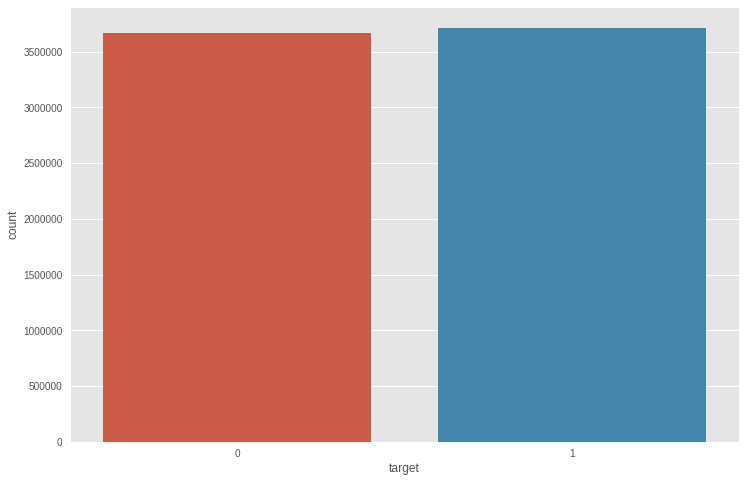

In [0]:
plt.figure(figsize=(12,8))
sns.countplot(data['target'])

***نمودار مقایسه تعداد پخش موزیک بر اساس سورس تایپ***

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


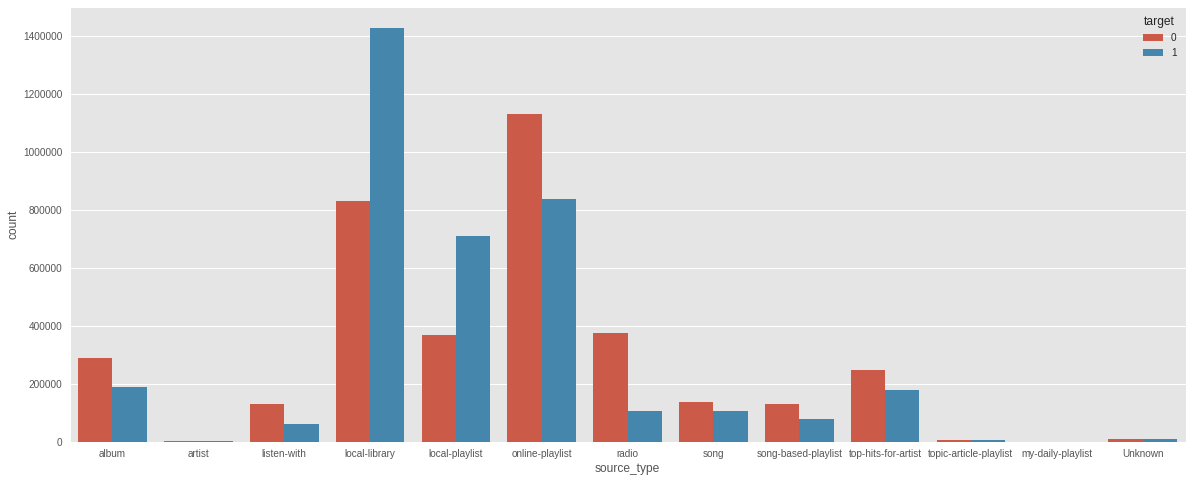

In [0]:
plt.figure(figsize=(20,8))
sns.countplot(data['source_type'], hue = data['target'])

# **نمودار تعداد پخشها برای زبان‌های مختلف**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


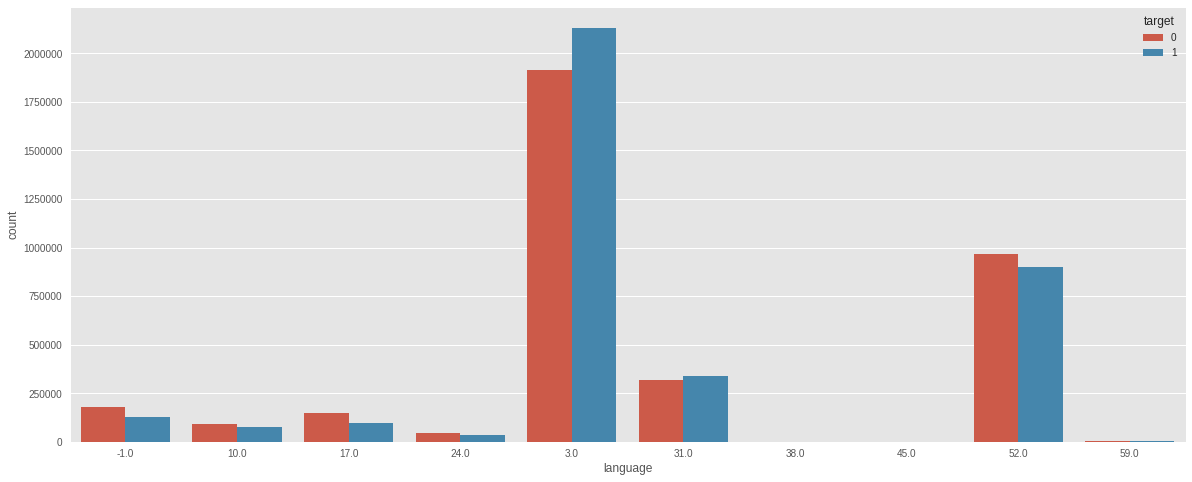

In [0]:
plt.figure(figsize=(20,8))
sns.countplot(data['language'], hue = data['target'])

# **نموارد تعداد آهنگ‌ها بر اساس سال ساخت**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


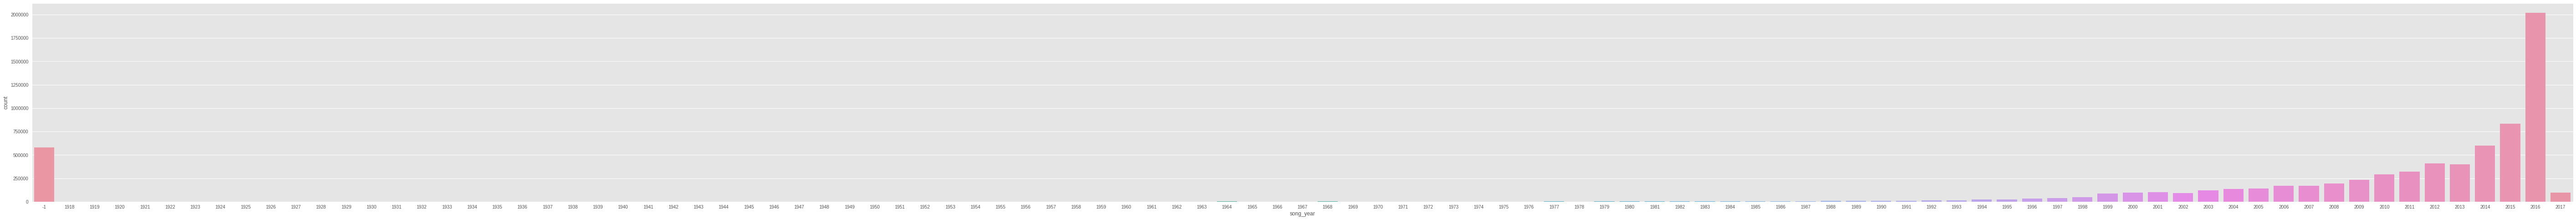

In [0]:
plt.figure(figsize=(100,8))
sns.countplot(data['song_year'])

# **نمودار تعداد کاربران بر اساس جنسیت**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


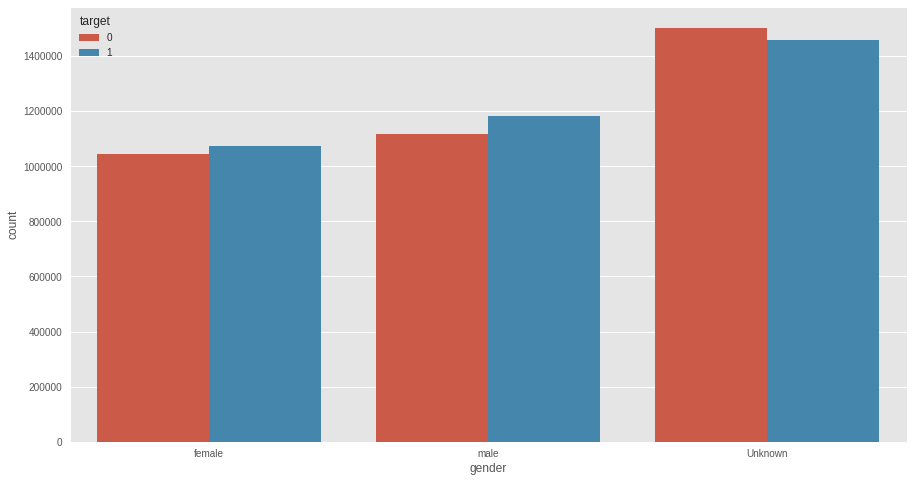

In [0]:
plt.figure(figsize=(15,8))
sns.countplot(data['gender'],  hue = data['target'])

# **جداسازی داده‌ها به دو بخش ترین و تست**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data.target, test_size=0.25, random_state=42)

In [0]:
# جداسازی داده‌هایی که تارگت آنها یک است از داده ترین

only_ones_data = X_train[y_train == 1]

In [0]:
len(only_ones_data)

2785348

In [0]:
# تعداد ژانرهای واحد

only_ones_data.genre_ids.nunique()

449

In [0]:
len(X_train)

5533063

# **بدست آوردن مقدار پخش بر اساس ژانر توسط هر کاربر**

In [0]:
counts = only_ones_data.groupby('msno')\
    .genre_ids.value_counts()\
    .to_frame()\
    .rename(columns={'genre_ids':'n_g_id'})
counts.head(10)

n_g_id
msno                                         genre_ids        
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 465           112
                                             458            25
                                             1259           20
                                             359            19
                                             474             9
                                             1609            8
                                             451             5
                                             1616|1609       4
                                             139             3
                                             2022            3

In [0]:
counts_copy = counts.copy()
counts_copy.reset_index(inplace=True)

# **ساخت یک دیتا فریم که ستون‌های آن تعداد پخش هر ژانر توسط هر کاربر را نشان می‌دهد**

In [0]:
counts_copy = counts_copy.groupby(['msno', 'genre_ids']).mean().squeeze().unstack().add_suffix('_count')
counts_copy.reset_index(inplace=True)
counts_copy.fillna(0, inplace=True)
counts_copy.head()

genre_ids,msno,1000_count,1007_count,1011_count,1011|691_count,1019_count,1033_count,1040_count,1040|1155_count,1047_count,...,958|2022_count,958|2122_count,958|691_count,958|786_count,958|947_count,965_count,972_count,979_count,986_count,993|751_count
0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **بدست آوردن تعداد کل پخش‌ها برای هر کاربر**

In [0]:
genre_sum = counts.groupby(level=0)\
    .sum()\
    .rename(columns={'n_g_id': 'n_d'})
genre_sum.head()

,n_d
msno,
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,212
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,100
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,54
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,1
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,66


# **بدست آوردن مقدار tf**

In [0]:
tf = counts.join(genre_sum)
tf['tf'] = tf.n_g_id/tf.n_d
tf.head()

n_g_id  n_d        tf
msno                                         genre_ids                       
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 465           112  212  0.528302
                                             458            25  212  0.117925
                                             1259           20  212  0.094340
                                             359            19  212  0.089623
                                             474             9  212  0.042453

In [0]:
# تعداد یوزرهای واحد

count_msno = only_ones_data.msno.nunique()
count_msno

26706

# **بدست آوردن idf**

In [0]:
idf = only_ones_data.groupby('genre_ids')\
    .msno\
    .nunique()\
    .to_frame()\
    .rename(columns={'msno':'u_i_d'})\
    .sort_values('u_i_d', ascending=False)
idf.head()

,u_i_d
genre_ids,
465,24632
458,22234
921,16503
1609,12772
451,10998


In [0]:
idf['idf'] = np.log(count_msno/idf.u_i_d.values)
idf.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


,u_i_d,idf
genre_ids,,
465,24632,0.080842
458,22234,0.183266
921,16503,0.481346
1609,12772,0.737633
451,10998,0.887175


In [0]:
tf_idf = tf.join(idf)
tf_idf.head()

n_g_id  n_d        tf  \
msno                                         genre_ids                          
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 465           112  212  0.528302   
                                             458            25  212  0.117925   
                                             1259           20  212  0.094340   
                                             359            19  212  0.089623   
                                             474             9  212  0.042453   

                                                        u_i_d       idf  
msno                                         genre_ids                   
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 465        24632  0.080842  
                                             458        22234  0.183266  
                                             1259       10716  0.913150  
                                             359         8364  1.160951  
                                             474           72  5.915977

# **محاسبه tf-idf**

In [0]:
tf_idf['tf_idf'] = tf_idf.tf * tf_idf.idf
tf_idf.head()

n_g_id  n_d        tf  \
msno                                         genre_ids                          
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 465           112  212  0.528302   
                                             458            25  212  0.117925   
                                             1259           20  212  0.094340   
                                             359            19  212  0.089623   
                                             474             9  212  0.042453   

                                                        u_i_d       idf  \
msno                                         genre_ids                    
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 465        24632  0.080842   
                                             458        22234  0.183266   
                                             1259       10716  0.913150   
                                             359         8364  1.160951   
                                             474           72  5.915977   

                                                          tf_idf  
msno                                         genre_ids            
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 465        0.042709  
                                             458        0.021612  
                                             1259       0.086146  
                                             359        0.104048  
                                             474        0.251150

In [0]:
tf_idf.drop('n_g_id', axis=1, inplace=True)
tf_idf.drop('n_d', axis=1, inplace=True)
tf_idf.drop('tf', axis=1, inplace=True)
tf_idf.drop('u_i_d', axis=1, inplace=True)
tf_idf.drop('idf', axis=1, inplace=True)
tf_idf.head()

tf_idf
msno                                         genre_ids          
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= 465        0.042709
                                             458        0.021612
                                             1259       0.086146
                                             359        0.104048
                                             474        0.251150

# **ساخت یک دیتافریم که ستون‌های آن مقدار تی‌اف‌آی‌دی‌اف هر ژانر برای هر کاربر را نشان می‌دهد**

In [0]:
genre_tfidf = tf_idf.copy()
genre_tfidf = genre_tfidf.groupby(['msno', 'genre_ids']).mean().squeeze().unstack().add_suffix('_tf_idf')
genre_tfidf.reset_index(inplace=True)
genre_tfidf.fillna(0, inplace=True)
genre_tfidf.head()

genre_ids,msno,1000_tf_idf,1007_tf_idf,1011_tf_idf,1011|691_tf_idf,1019_tf_idf,1033_tf_idf,1040_tf_idf,1040|1155_tf_idf,1047_tf_idf,...,958|2022_tf_idf,958|2122_tf_idf,958|691_tf_idf,958|786_tf_idf,958|947_tf_idf,965_tf_idf,972_tf_idf,979_tf_idf,986_tf_idf,993|751_tf_idf
0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.0,0.0,0.053929,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,0.0,0.0,0.027237,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
genre_tfidf.columns = np.arange(len(genre_tfidf.columns))
genre_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,440,441,442,443,444,445,446,447,448,449
0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.0,0.0,0.053929,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,0.0,0.0,0.027237,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **تبدیل دیتافریم به sparse matrix**

In [0]:
matrix = genre_tfidf.drop(0, axis=1)
matrix.head()

,1,2,3,4,5,6,7,8,9,10,...,440,441,442,443,444,445,446,447,448,449
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.053929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.027237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
csr_matrix_data  = csr_matrix(matrix.values)
csr_matrix_data = normalize(csr_matrix_data)
csr_matrix_data

<26671x449 sparse matrix of type '<class 'numpy.float64'>'
	with 233712 stored elements in Compressed Sparse Row format>

# ** تابع‌های مربوط به کلاستر بندی**

In [0]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

In [0]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    
    return cluster_assignment

In [0]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

In [0]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [0]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        # YOUR CODE HERE
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        # YOUR CODE HERE
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # YOUR CODE HERE
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [0]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [0]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2,axis=1)
    
    return centroids

In [0]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in range(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
        # YOUR CODE HERE
        initial_centroids = smart_initialize(data, k, seed=seed)
        
        # Run k-means
        # YOUR CODE HERE
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False)
        
        # To save time, compute heterogeneity only once in the end
        # YOUR CODE HERE
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

In [0]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
   plt.figure(figsize=(7,4))
   plt.plot(k_values, heterogeneity_values, linewidth=4)
   plt.xlabel('K')
   plt.ylabel('Heterogeneity')
   plt.title('K vs. Heterogeneity')
   plt.rcParams.update({'font.size': 16})
   plt.tight_layout()

# **محاسبه همگرایی و پیدا کردن تعداد کلاستر بهینه**

1277.1517169475555


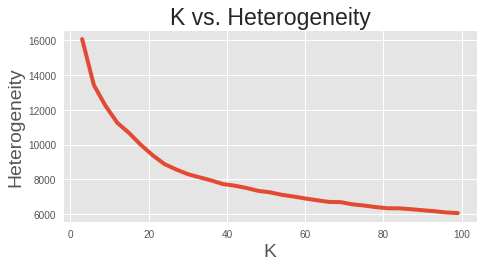

In [0]:
start = time.time()
centroids = {}
cluster_assignment = {}
heterogeneity_values = []
k_list = np.arange(3,100,3)
seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]
000600
for k in k_list:
   heterogeneity = []
   centroids[k], cluster_assignment[k] = kmeans_multiple_runs(csr_matrix_data, k, maxiter=600,
                                                              num_runs=len(seed_list),
                                                              seed_list=seed_list,
                                                              verbose=False)
   score = compute_heterogeneity(csr_matrix_data, k, centroids[k], cluster_assignment[k])
   heterogeneity_values.append(score)

plot_k_vs_heterogeneity(k_list, heterogeneity_values)

end = time.time()
print(end-start)

# **انتخاب ۳۰ کلاستر و اعمال الگوریتم بر روی داده‌ها**

In [0]:
seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]
cent, assign = kmeans_multiple_runs(csr_matrix_data, 30, maxiter=600, num_runs=len(seed_list),
                                                              seed_list=seed_list,
                                                              verbose=True)

seed=000000, heterogeneity=8408.76728
seed=020000, heterogeneity=8552.06792
seed=040000, heterogeneity=8467.29225
seed=060000, heterogeneity=8915.52561
seed=080000, heterogeneity=8502.83222
seed=100000, heterogeneity=8353.65305
seed=120000, heterogeneity=8303.47917


# **مشخص کردن کلاستر هر کاربر و نمایش آن بصورت یک دیتا فریم**

In [0]:
#counts_copy.drop('cluster', axis=1, inplace=True)
counts_copy['cluster'] = assign.tolist()
counts_copy.head(10)

genre_ids,msno,1000_count,1007_count,1011_count,1011|691_count,1019_count,1033_count,1040_count,1040|1155_count,1047_count,...,958|2122_count,958|691_count,958|786_count,958|947_count,965_count,972_count,979_count,986_count,993|751_count,cluster
0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
1,++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
2,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13
3,++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
5,+/UwoUi5+rNj/F6RO6gMrMhOy0oTzs90MWKVNZs4+Wg=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24
6,+/tv7+daiSsEEBhNDnQZL32wdfmr2GSYmX2aQPGONRY=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
7,+/vppV5BoMKMNAk7Bej5rjhKeE6VqrRjUv8EYXoAjyM=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,+0+XaewkS3za58vHwKCVGwRYRvjig4lTtKDV/tOkzbU=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
9,+06pc1V8QfywrGOTNln/7X7Md8dA8fVOIU37n2M5mv8=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17


In [0]:
counts_index = counts.reset_index()
counts_index.head()

,msno,genre_ids,n_g_id
0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,465,112
1,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,458,25
2,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,1259,20
3,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,359,19
4,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,474,9


# **بعنوان تست کاربران کلاستر ۱۲ را بدست می‌آوریم تا مقدار شباهتشان را بسنجیم**

In [0]:
counts_copy[counts_copy['cluster'] == 12]

genre_ids,msno,1000_count,1007_count,1011_count,1011|691_count,1019_count,1033_count,1040_count,1040|1155_count,1047_count,...,958|2122_count,958|691_count,958|786_count,958|947_count,965_count,972_count,979_count,986_count,993|751_count,cluster
32,+46pWXPf+T7o/txKF412S8ThB4D8YdbL6jmWWOcJEx8=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
39,+4yiZ/usBfNb5DbUfDRue4QFUye6FUtBr8wxJGIXljU=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
61,+8MWYLmsp600Ok8d1IfiFTaQgRKrWqRbbnLowiNMCF8=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
75,+AOYsZDNy2tWIejwWiE8fvcuhGJPogcMaILX4av1znY=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
83,+BeC63qvTFGBiaaDDiQJfsQNtjRGHWbALHXZUurCZS8=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
87,+DGK04CjTamgGx4qENuvg1QjV/KZT2IJf46OFnjadgo=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
91,+DmyAJIQzPm67q0VlGp79qpL6piCnqCxqfcxaxCUZ/E=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
98,+Ez0nI/qWfSARukmK2mqdW6rffcVoJf5y74BEo+7NQ0=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
134,+M/4UTmQHhLMMsQfavQ6WxIIqhGx+dqJhFqK60Cx4FU=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
291,+lB+ouuw4P+aq7P1GxnuMvF/vo1Kb2TsH15sP/AD4ow=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12


# **مقایسه دو کاربر از کلاستر ۱۲ و تعداد پخش‌های آن‌ها بر اساس ژانر**

In [0]:
counts_index[counts_index['msno'] == 'wwYwkddCqNCAHUTkwco9wOb/P5JJ0cXsvIwD3MInsFQ=']

,msno,genre_ids,n_g_id
222678,wwYwkddCqNCAHUTkwco9wOb/P5JJ0cXsvIwD3MInsFQ=,465,169
222679,wwYwkddCqNCAHUTkwco9wOb/P5JJ0cXsvIwD3MInsFQ=,458,44
222680,wwYwkddCqNCAHUTkwco9wOb/P5JJ0cXsvIwD3MInsFQ=,2157,11
222681,wwYwkddCqNCAHUTkwco9wOb/P5JJ0cXsvIwD3MInsFQ=,451,4
222682,wwYwkddCqNCAHUTkwco9wOb/P5JJ0cXsvIwD3MInsFQ=,921,3
222683,wwYwkddCqNCAHUTkwco9wOb/P5JJ0cXsvIwD3MInsFQ=,1259,1
222684,wwYwkddCqNCAHUTkwco9wOb/P5JJ0cXsvIwD3MInsFQ=,2022,1
222685,wwYwkddCqNCAHUTkwco9wOb/P5JJ0cXsvIwD3MInsFQ=,465|458,1
222686,wwYwkddCqNCAHUTkwco9wOb/P5JJ0cXsvIwD3MInsFQ=,465|921,1
222687,wwYwkddCqNCAHUTkwco9wOb/P5JJ0cXsvIwD3MInsFQ=,691,1


# **مشاهده می‌کنیم که این دو کاربر به ژانرهای ۴۶۵ و ۴۵۸ و ۲۱۵۷ و ۴۵۱ علاقه بیشتری دارند**

In [0]:
counts_index[counts_index['msno'] == '0+5iukg08KTgEI42al05Xja6feBDRsGdjM5RvaUJt+4=']

,msno,genre_ids,n_g_id
6810,0+5iukg08KTgEI42al05Xja6feBDRsGdjM5RvaUJt+4=,465,148
6811,0+5iukg08KTgEI42al05Xja6feBDRsGdjM5RvaUJt+4=,458,75
6812,0+5iukg08KTgEI42al05Xja6feBDRsGdjM5RvaUJt+4=,2157,8
6813,0+5iukg08KTgEI42al05Xja6feBDRsGdjM5RvaUJt+4=,921|458,3
6814,0+5iukg08KTgEI42al05Xja6feBDRsGdjM5RvaUJt+4=,2022,2
6815,0+5iukg08KTgEI42al05Xja6feBDRsGdjM5RvaUJt+4=,451,2
6816,0+5iukg08KTgEI42al05Xja6feBDRsGdjM5RvaUJt+4=,921,2
6817,0+5iukg08KTgEI42al05Xja6feBDRsGdjM5RvaUJt+4=,444,1
6818,0+5iukg08KTgEI42al05Xja6feBDRsGdjM5RvaUJt+4=,465|458,1
6819,0+5iukg08KTgEI42al05Xja6feBDRsGdjM5RvaUJt+4=,829,1


In [0]:
y = counts_copy['cluster']
X = counts_copy.ix[:, '1000_count':'993|751_count']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


# **رسم نمودارها برای مشاهده کلاسترینگ به ۳ روش**

In [0]:
X_norm = (X - X.min())/(X.max() - X.min())

# **LDA**

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


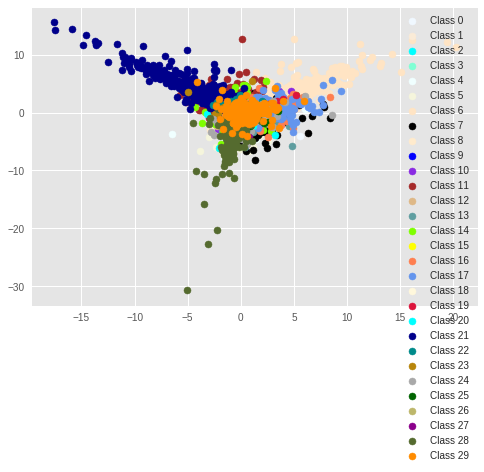

In [0]:
# LDA 2 dimensional plot
lda = LDA(n_components=2) #2-dimensional LDA
transformed = pd.DataFrame(lda.fit_transform(X_norm, y))
#########################################################
plt.scatter(transformed[y==0][0], transformed[y==0][1], label='Class 0', c='aliceblue')
plt.scatter(transformed[y==1][0], transformed[y==1][1], label='Class 1', c='antiquewhite')
plt.scatter(transformed[y==2][0], transformed[y==2][1], label='Class 2', c='aqua')
plt.scatter(transformed[y==3][0], transformed[y==3][1], label='Class 3', c='aquamarine')
plt.scatter(transformed[y==4][0], transformed[y==4][1], label='Class 4', c='azure')
plt.scatter(transformed[y==5][0], transformed[y==5][1], label='Class 5', c='beige')
plt.scatter(transformed[y==6][0], transformed[y==6][1], label='Class 6', c='bisque')
plt.scatter(transformed[y==7][0], transformed[y==7][1], label='Class 7', c='black')
plt.scatter(transformed[y==8][0], transformed[y==8][1], label='Class 8', c='blanchedalmond')
plt.scatter(transformed[y==9][0], transformed[y==9][1], label='Class 9', c='blue')
plt.scatter(transformed[y==10][0], transformed[y==10][1], label='Class 10', c='blueviolet')
plt.scatter(transformed[y==11][0], transformed[y==11][1], label='Class 11', c='brown')
plt.scatter(transformed[y==12][0], transformed[y==12][1], label='Class 12', c='burlywood')
plt.scatter(transformed[y==13][0], transformed[y==13][1], label='Class 13', c='cadetblue')
plt.scatter(transformed[y==14][0], transformed[y==14][1], label='Class 14', c='chartreuse')
plt.scatter(transformed[y==15][0], transformed[y==15][1], label='Class 15', c='yellow')
plt.scatter(transformed[y==16][0], transformed[y==16][1], label='Class 16', c='coral')
plt.scatter(transformed[y==17][0], transformed[y==17][1], label='Class 17', c='cornflowerblue')
plt.scatter(transformed[y==18][0], transformed[y==18][1], label='Class 18', c='cornsilk')
plt.scatter(transformed[y==19][0], transformed[y==19][1], label='Class 19', c='crimson')
plt.scatter(transformed[y==20][0], transformed[y==20][1], label='Class 20', c='cyan')
plt.scatter(transformed[y==21][0], transformed[y==21][1], label='Class 21', c='darkblue')
plt.scatter(transformed[y==22][0], transformed[y==22][1], label='Class 22', c='darkcyan')
plt.scatter(transformed[y==23][0], transformed[y==23][1], label='Class 23', c='darkgoldenrod')
plt.scatter(transformed[y==24][0], transformed[y==24][1], label='Class 24', c='darkgray')
plt.scatter(transformed[y==25][0], transformed[y==25][1], label='Class 25', c='darkgreen')
plt.scatter(transformed[y==26][0], transformed[y==26][1], label='Class 26', c='darkkhaki')
plt.scatter(transformed[y==27][0], transformed[y==27][1], label='Class 27', c='darkmagenta')
plt.scatter(transformed[y==28][0], transformed[y==28][1], label='Class 28', c='darkolivegreen')
plt.scatter(transformed[y==29][0], transformed[y==29][1], label='Class 29', c='darkorange')

plt.legend()
plt.show()

# **PCA**

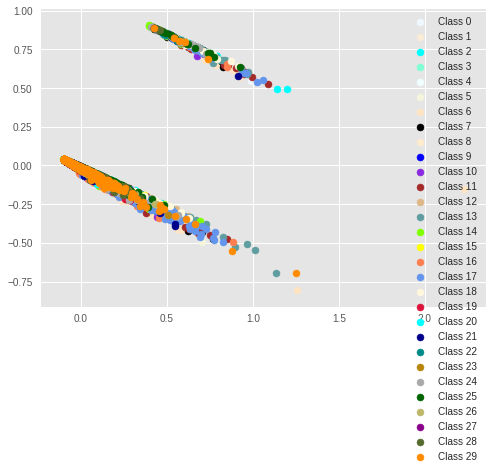

In [0]:
# PCA 2 dimensional plot
pca = PCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X_norm))
###################################################

plt.scatter(transformed[y==0][0], transformed[y==0][1], label='Class 0', c='aliceblue')
plt.scatter(transformed[y==1][0], transformed[y==1][1], label='Class 1', c='antiquewhite')
plt.scatter(transformed[y==2][0], transformed[y==2][1], label='Class 2', c='aqua')
plt.scatter(transformed[y==3][0], transformed[y==3][1], label='Class 3', c='aquamarine')
plt.scatter(transformed[y==4][0], transformed[y==4][1], label='Class 4', c='azure')
plt.scatter(transformed[y==5][0], transformed[y==5][1], label='Class 5', c='beige')
plt.scatter(transformed[y==6][0], transformed[y==6][1], label='Class 6', c='bisque')
plt.scatter(transformed[y==7][0], transformed[y==7][1], label='Class 7', c='black')
plt.scatter(transformed[y==8][0], transformed[y==8][1], label='Class 8', c='blanchedalmond')
plt.scatter(transformed[y==9][0], transformed[y==9][1], label='Class 9', c='blue')
plt.scatter(transformed[y==10][0], transformed[y==10][1], label='Class 10', c='blueviolet')
plt.scatter(transformed[y==11][0], transformed[y==11][1], label='Class 11', c='brown')
plt.scatter(transformed[y==12][0], transformed[y==12][1], label='Class 12', c='burlywood')
plt.scatter(transformed[y==13][0], transformed[y==13][1], label='Class 13', c='cadetblue')
plt.scatter(transformed[y==14][0], transformed[y==14][1], label='Class 14', c='chartreuse')
plt.scatter(transformed[y==15][0], transformed[y==15][1], label='Class 15', c='yellow')
plt.scatter(transformed[y==16][0], transformed[y==16][1], label='Class 16', c='coral')
plt.scatter(transformed[y==17][0], transformed[y==17][1], label='Class 17', c='cornflowerblue')
plt.scatter(transformed[y==18][0], transformed[y==18][1], label='Class 18', c='cornsilk')
plt.scatter(transformed[y==19][0], transformed[y==19][1], label='Class 19', c='crimson')
plt.scatter(transformed[y==20][0], transformed[y==20][1], label='Class 20', c='cyan')
plt.scatter(transformed[y==21][0], transformed[y==21][1], label='Class 21', c='darkblue')
plt.scatter(transformed[y==22][0], transformed[y==22][1], label='Class 22', c='darkcyan')
plt.scatter(transformed[y==23][0], transformed[y==23][1], label='Class 23', c='darkgoldenrod')
plt.scatter(transformed[y==24][0], transformed[y==24][1], label='Class 24', c='darkgray')
plt.scatter(transformed[y==25][0], transformed[y==25][1], label='Class 25', c='darkgreen')
plt.scatter(transformed[y==26][0], transformed[y==26][1], label='Class 26', c='darkkhaki')
plt.scatter(transformed[y==27][0], transformed[y==27][1], label='Class 27', c='darkmagenta')
plt.scatter(transformed[y==28][0], transformed[y==28][1], label='Class 28', c='darkolivegreen')
plt.scatter(transformed[y==29][0], transformed[y==29][1], label='Class 29', c='darkorange')

plt.legend()
plt.show()

# **Simple 2 dimensional plot**

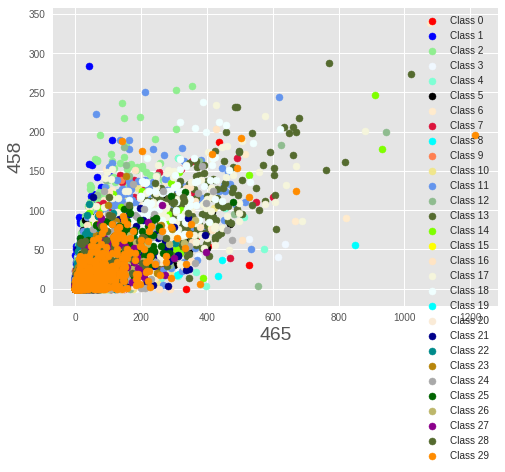

In [0]:
# Simple 2 dimensional plot
plt.scatter(X[y==0]['465_count'], X[y==0]['458_count'], label='Class 0', c='red')
plt.scatter(X[y==1]['465_count'], X[y==1]['458_count'], label='Class 1', c='blue')
plt.scatter(X[y==2]['465_count'], X[y==2]['458_count'], label='Class 2', c='lightgreen')
plt.scatter(X[y==3]['465_count'], X[y==3]['458_count'], label='Class 3', c='aliceblue')
plt.scatter(X[y==4]['465_count'], X[y==4]['458_count'], label='Class 4', c='aquamarine')
plt.scatter(X[y==5]['465_count'], X[y==5]['458_count'], label='Class 5', c='black')
plt.scatter(X[y==6]['465_count'], X[y==6]['458_count'], label='Class 6', c='blanchedalmond')
plt.scatter(X[y==7]['465_count'], X[y==7]['458_count'], label='Class 7', c='crimson')
plt.scatter(X[y==8]['465_count'], X[y==8]['458_count'], label='Class 8', c='cyan')
plt.scatter(X[y==9]['465_count'], X[y==9]['458_count'], label='Class 9', c='coral')
plt.scatter(X[y==10]['465_count'], X[y==10]['458_count'], label='Class 10', c='khaki')
plt.scatter(X[y==11]['465_count'], X[y==11]['458_count'], label='Class 11', c='cornflowerblue')
plt.scatter(X[y==12]['465_count'], X[y==12]['458_count'], label='Class 12', c='darkseagreen')
plt.scatter(X[y==13]['465_count'], X[y==13]['458_count'], label='Class 13', c='darkolivegreen')
plt.scatter(X[y==14]['465_count'], X[y==14]['458_count'], label='Class 14', c='chartreuse')
plt.scatter(X[y==15]['465_count'], X[y==15]['458_count'], label='Class 15', c='yellow')
plt.scatter(X[y==16]['465_count'], X[y==16]['458_count'], label='Class 16', c='bisque')
plt.scatter(X[y==17]['465_count'], X[y==17]['458_count'], label='Class 17', c='beige')
plt.scatter(X[y==18]['465_count'], X[y==18]['458_count'], label='Class 18', c='azure')
plt.scatter(X[y==19]['465_count'], X[y==19]['458_count'], label='Class 19', c='aqua')
plt.scatter(X[y==20]['465_count'], X[y==20]['458_count'], label='Class 20', c='antiquewhite')
plt.scatter(X[y==21]['465_count'], X[y==21]['458_count'], label='Class 21', c='darkblue')
plt.scatter(X[y==22]['465_count'], X[y==22]['458_count'], label='Class 22', c='darkcyan')
plt.scatter(X[y==23]['465_count'], X[y==23]['458_count'], label='Class 23', c='darkgoldenrod')
plt.scatter(X[y==24]['465_count'], X[y==24]['458_count'], label='Class 24', c='darkgray')
plt.scatter(X[y==25]['465_count'], X[y==25]['458_count'], label='Class 25', c='darkgreen')
plt.scatter(X[y==26]['465_count'], X[y==26]['458_count'], label='Class 26', c='darkkhaki')
plt.scatter(X[y==27]['465_count'], X[y==27]['458_count'], label='Class 27', c='darkmagenta')
plt.scatter(X[y==28]['465_count'], X[y==28]['458_count'], label='Class 28', c='darkolivegreen')
plt.scatter(X[y==29]['465_count'], X[y==29]['458_count'], label='Class 29', c='darkorange')

# Prettify the graph
plt.legend()
plt.xlabel('465')
plt.ylabel('458')

# display
plt.show()

# **ساخت یک دیتا فریم شامل فقط کاربران و کلاستر آن‌ها**

In [0]:
new = counts_copy[['msno', 'cluster']]
new.head()

genre_ids,msno,cluster
0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,16
1,++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,17
2,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,13
3,++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,1
4,+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,17


# **مرج کردن و مشخص کردن کلاستر همه کاربران برای داده‌های ترین**

In [0]:
X_train_cluster = pd.merge(X_train, y_train.to_frame(), left_index=True, right_index=True)
X_train_cluster = X_train_cluster.merge(new, how='left', on='msno')
X_train_cluster['cluster'].fillna(value=X_train_cluster['cluster'].mode()[0],inplace=True)
X_train_cluster['cluster'] = X_train_cluster['cluster'].astype(np.int8)
X_train_cluster['cluster'].dtype
X_train_cluster['cluster'].isnull().sum()

0

# **مرج کردن و مشخص کردن کلاستر همه کاربران برای داده‌های تست**

In [0]:
X_test_cluster = pd.merge(X_test, y_test.to_frame(), left_index=True, right_index=True)
X_test_cluster = X_test_cluster.merge(new, how='left', on='msno')
X_test_cluster['cluster'].fillna(value=X_test_cluster['cluster'].mode()[0],inplace=True)
X_test_cluster['cluster'] = X_test_cluster['cluster'].astype(np.int8)
X_test_cluster['cluster'].dtype
X_test_cluster['cluster'].isnull().sum()

0

# **پر کردن مقادیر نال در داده‌های ترین و تست برای هر ستون**

In [0]:
X_train_cluster['gender'] = X_train_cluster['gender'].cat.add_categories(["Unknown"])
X_train_cluster['gender'].fillna(value='Unknown',inplace=True)

X_test_cluster['gender'] = X_test_cluster['gender'].cat.add_categories(["Unknown"])
X_test_cluster['gender'].fillna(value='Unknown',inplace=True)

In [0]:
X_train_cluster['source_system_tab'] = X_train_cluster['source_system_tab'].cat.add_categories(["Unknown"])
X_train_cluster['source_system_tab'].fillna(value="Unknown",inplace=True)

X_test_cluster['source_system_tab'] = X_test_cluster['source_system_tab'].cat.add_categories(["Unknown"])
X_test_cluster['source_system_tab'].fillna(value="Unknown",inplace=True)

In [0]:
#X_train_cluster['source_screen_name'] = X_train_cluster['source_screen_name'].cat.add_categories(["Unknown"])
X_train_cluster['source_screen_name'].fillna(value="Unknown",inplace=True)

#X_test_cluster['source_screen_name'] = X_test_cluster['source_screen_name'].cat.add_categories(["Unknown"])
X_test_cluster['source_screen_name'].fillna(value="Unknown",inplace=True)

In [0]:
X_train_cluster['source_type'] = X_train_cluster['source_type'].cat.add_categories(["Unknown"])
X_train_cluster['source_type'].fillna(value="Unknown",inplace=True)

X_test_cluster['source_type'] = X_test_cluster['source_type'].cat.add_categories(["Unknown"])
X_test_cluster['source_type'].fillna(value="Unknown",inplace=True)

In [0]:
X_train_cluster['genre_ids'] = X_train_cluster['genre_ids'].cat.add_categories(["Unknown"])
X_train_cluster['genre_ids'].fillna(value="Unknown",inplace=True)
X_train_cluster['genre_ids_count'] = X_train_cluster['genre_ids'].apply(genre_id_count).astype(np.int8)

X_test_cluster['genre_ids'] = X_test_cluster['genre_ids'].cat.add_categories(["Unknown"])
X_test_cluster['genre_ids'].fillna(value="Unknown",inplace=True)
X_test_cluster['genre_ids_count'] = X_test_cluster['genre_ids'].apply(genre_id_count).astype(np.int8)

In [0]:
#X_train_cluster['artist_name'] = X_train_cluster['artist_name'].cat.add_categories(["Unknown"])
X_train_cluster['artist_name'].fillna(value="Unknown",inplace=True)

#X_test_cluster['artist_name'] = X_test_cluster['artist_name'].cat.add_categories(["Unknown"])
X_test_cluster['artist_name'].fillna(value="Unknown",inplace=True)

In [0]:
#X_train_cluster['composer'] = X_train_cluster['composer'].cat.add_categories(["Unknown"])
X_train_cluster['composer'].fillna(value="Unknown",inplace=True)
X_train_cluster['composer_count'] = X_train_cluster['composer'].apply(composer_count).astype(np.int8)

#X_test_cluster['composer'] = X_test_cluster['composer'].cat.add_categories(["Unknown"])
X_test_cluster['composer'].fillna(value="Unknown",inplace=True)
X_test_cluster['composer_count'] = X_test_cluster['composer'].apply(composer_count).astype(np.int8)

In [0]:
#X_train_cluster['lyricist'] = X_train_cluster['lyricist'].cat.add_categories(["Unknown"])
X_train_cluster['lyricist'].fillna(value="Unknown",inplace=True)
X_train_cluster['lyricists_count'] = X_train_cluster['lyricist'].apply(lyricist_count).astype(np.int8)

#X_test_cluster['lyricist'] = X_test_cluster['lyricist'].cat.add_categories(["Unknown"])
X_test_cluster['lyricist'].fillna(value="Unknown",inplace=True)
X_test_cluster['lyricists_count'] = X_test_cluster['lyricist'].apply(lyricist_count).astype(np.int8)

In [0]:
X_train_cluster['name'] = X_train_cluster['name'].astype('category')
#X_train_cluster['name'] = X_train_cluster['name'].cat.add_categories(["Unknown"])
X_train_cluster['name'].fillna(value='Unknown',inplace=True)

X_test_cluster['name'] = X_test_cluster['name'].astype('category')
#X_test_cluster['name'] = X_test_cluster['name'].cat.add_categories(["Unknown"])
X_test_cluster['name'].fillna(value='Unknown',inplace=True)

In [0]:
X_train_cluster['song_year'].fillna(value=-1,inplace=True)

X_test_cluster['song_year'].fillna(value=-1,inplace=True)

In [0]:
X_train_cluster['song_length'].fillna(value=X_train_cluster['song_length'].mean(),inplace=True)

X_test_cluster['song_length'].fillna(value=X_test_cluster['song_length'].mean(),inplace=True)

In [0]:
X_train_cluster['language'].fillna(value=X_train_cluster['language'].mode()[0],inplace=True)

X_test_cluster['language'].fillna(value=X_test_cluster['language'].mode()[0],inplace=True)

In [0]:
X_train_cluster.drop('isrc', axis=1, inplace=True)
X_train_cluster.drop('registration_init_time', axis=1, inplace=True)

X_test_cluster.drop('isrc', axis=1, inplace=True)
X_test_cluster.drop('registration_init_time', axis=1, inplace=True)

In [0]:
X_train_cluster_copy = X_train_cluster.copy()
X_test_cluster_copy =  X_test_cluster.copy()

# **بدست آوردن درصد پخش آهنگ از هر خواننده**

In [0]:
df_artists = X_train_cluster_copy.loc[:,["artist_name","target"]]

artists1 = df_artists.groupby(["artist_name"],as_index=False).sum().rename(columns={"target":"repeat_count"})

artists2 = df_artists.groupby(["artist_name"],as_index=False).count().rename(columns = {"target":"play_count"})
df_artist_repeats = artists1.merge(artists2,how="inner",on="artist_name")
df_artist_repeats["repeat_percentage"] = round((df_artist_repeats['repeat_count']*100) / df_artist_repeats['play_count'],1)
df_artist_repeats.drop(["repeat_count","play_count"],axis=1,inplace=True)
X_train_cluster_copy = X_train_cluster_copy.merge(df_artist_repeats,on="artist_name",how="left").rename(columns={"repeat_percentage":"artist_repeat_percentage"})
X_test_cluster_copy = X_test_cluster_copy.merge(df_artist_repeats,on="artist_name",how="left").rename(columns={"repeat_percentage":"artist_repeat_percentage"})

X_train_cluster_copy.drop(["genre_ids","artist_name"],axis=1,inplace=True)

X_test_cluster_copy.drop(["genre_ids","artist_name"],axis=1,inplace=True)

del df_artist_repeats
del df_artists

# **تبدیل داده‌های کتگوریکال بصورت عددی**

In [0]:
source_tab_dict = {"my library":8,"discover":7,"search":6,"radio":5,"listen with":4,"explore":3,"notification":2,"settings":1,"Unknown":0 }

source_screen_name_dict = {"Local playlist more":19,"Online playlist more":18,"Radio":17,"Unknown":16,"Album more":15,"Search":14,"Artist more":13,"Discover Feature":12,"Discover Chart":11,"Others profile more":10,"Discover Genre":9,"My library":8,"Explore":7,"Discover New":6,"Search Trends":5,"Search Home":4,"My library_Search":3,"Self profile more":2,"Concert":1,"Payment":0}

source_type_dict = {"local-library":12,"online-playlist":11,"local-playlist":10,"radio":9,"album":8,"top-hits-for-artist":7,"song":6,"song-based-playlist":5,"listen-with":4,"Unknown":3,"topic-article-playlist":2,"artist":1,"my-daily-playlist":0}

In [0]:
X_train_cluster_copy['source_system_tab'] = X_train_cluster_copy['source_system_tab'].map(source_tab_dict)

X_test_cluster_copy['source_system_tab'] = X_test_cluster_copy['source_system_tab'].map(source_tab_dict)

X_train_cluster_copy['source_type'] = X_train_cluster_copy['source_type'].map(source_type_dict)
X_test_cluster_copy['source_type'] = X_test_cluster_copy['source_type'].map(source_type_dict)

X_train_cluster_copy['source_screen_name'] = X_train_cluster_copy['source_screen_name'].map(source_screen_name_dict)
X_test_cluster_copy['source_screen_name'] = X_test_cluster_copy['source_screen_name'].map(source_screen_name_dict)

# **تبدیل ستون جنست به one hot encoding**

In [0]:
gender_train = pd.get_dummies(X_train_cluster_copy['gender'],drop_first=True)

gender_test = pd.get_dummies(X_test_cluster_copy['gender'],drop_first=True)

In [0]:
X_train_cluster_copy = pd.concat([X_train_cluster_copy,gender_train],axis=1)
X_test_cluster_copy = pd.concat([X_test_cluster_copy,gender_test],axis=1)

# **حذف داده‌هایی که مورد نیاز نیستند**

In [0]:
X_train_cluster_copy.drop(["composer","gender"],axis=1,inplace=True)
X_test_cluster_copy.drop(["composer","gender"],axis=1,inplace=True)

In [0]:
X_train_cluster_copy.drop(['registration_year', 'registration_month', 'registration_date', 'expiration_year', 'expiration_month'],axis=1,inplace=True)
X_test_cluster_copy.drop(['registration_year', 'registration_month', 'registration_date', 'expiration_year', 'expiration_month'],axis=1,inplace=True)

In [0]:
X_test_cluster_copy['artist_repeat_percentage'].fillna(value=0.0,inplace=True)
X_test_cluster_copy['source_screen_name'].fillna(X_test_cluster_copy['source_screen_name'].mode()[0],inplace=True)
X_train_cluster_copy.drop("lyricist",axis=1,inplace=True)

X_test_cluster_copy.drop("lyricist",axis=1,inplace=True)
X_train_cluster_copy.drop("name",axis=1,inplace=True)
X_test_cluster_copy.drop("name",axis=1,inplace=True)
X_train_cluster_copy['song_year'] = X_train_cluster['song_year'].astype("int")
X_test_cluster_copy['song_year'] = X_test_cluster_copy['song_year'].astype("int")

# **تبدیل ستون سن به ۶ بخش برای سادگی در محاسبات**

In [0]:
X_train_cluster_copy['age_range'] = pd.cut(X_train_cluster_copy['bd'],bins=[-45,0,10,18,35,50,80,1052])
X_test_cluster_copy['age_range'] = pd.cut(X_test_cluster_copy['bd'],bins=[-45,0,10,18,35,50,80,1052])

combine = [X_train_cluster_copy, X_test_cluster_copy]

for dataset in combine : 
    
    dataset.loc[(dataset['bd'] > 0) & (dataset['bd'] <= 10), 'age_category'] = 0
    dataset.loc[(dataset['bd'] > 80) & (dataset['bd'] <= 1052), 'age_category'] = 1
    dataset.loc[(dataset['bd'] > 50) & (dataset['bd'] <= 80), 'age_category'] = 2
    dataset.loc[(dataset['bd'] > 10) & (dataset['bd'] <= 18), 'age_category'] = 3
    dataset.loc[(dataset['bd'] > 35) & (dataset['bd'] <= 50), 'age_category'] = 4
    dataset.loc[(dataset['bd'] > -45) & (dataset['bd'] <= 0), 'age_category'] = 5
    dataset.loc[(dataset['bd'] > 18) & (dataset['bd'] <= 35), 'age_category'] = 6

X_train_cluster_copy.drop(["age_range","bd"],axis=1,inplace=True)
X_test_cluster_copy.drop(["age_range","bd"],axis=1,inplace=True)

# **تبدیل تمامی داده‌های کتگوریکال به عدد به صورت یکجا**

In [0]:
# Object data to category
for col in X_train_cluster_copy.select_dtypes(include=['object']).columns:
    X_train_cluster_copy[col] = X_train_cluster_copy[col].astype('category')
    
# Encoding categorical features
for col in X_train_cluster_copy.select_dtypes(include=['category']).columns:
    X_train_cluster_copy[col] = X_train_cluster_copy[col].cat.codes

# Object data to category
for col in X_test_cluster_copy.select_dtypes(include=['object']).columns:
    X_test_cluster_copy[col] = X_test_cluster_copy[col].astype('category')
   
# Encoding categorical features
for col in X_test_cluster_copy.select_dtypes(include=['category']).columns:
    X_test_cluster_copy[col] = X_test_cluster_copy[col].cat.codes


# **جداسازی دیتاها بر اساس کلاستر و ذخیره آن‌ها بصورت دیتافریم‌های جداگانه**

In [0]:
for i in range(0,30):
  locals()['train_data_cluster_{0}'.format(i)] = X_train_cluster_copy[X_train_cluster_copy['cluster'] == i]

In [0]:
for j in range(0,30):
  locals()['test_data_cluster_{0}'.format(j)] = X_test_cluster_copy[X_test_cluster_copy['cluster'] == j]

# **ساخت و آموزش مدل XGboost**

In [0]:
model_XG = xgb.XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=250)

In [0]:
X = X_train_cluster_copy.drop(["msno","song_id","target"],axis=1).values

y = X_train_cluster_copy['target'].values

In [0]:
model_XG.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=10, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
test_labels = X_test_cluster_copy['target']

X_test = X_test_cluster_copy.drop(["msno","song_id","target"],axis=1).values

In [0]:
pre = model_XG.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [0]:
print(metrics.classification_report(test_labels, pre))

             precision    recall  f1-score   support

          0       0.71      0.67      0.69    915047
          1       0.69      0.73      0.71    929308

avg / total       0.70      0.70      0.70   1844355



# **مقدار AUC XGboost**

In [0]:
y_test = np.array(test_labels)
pred = np.array(pre)
fpr, tpr, thresholds = roc_curve(y_test, pred)
a = roc_auc_score(y_test, pred)
print(a)

0.6977086996768038


# **ساخت و آموزش مدل LightGboost**

In [0]:
X_train_cluster_copy['source_system_tab'] = X_train_cluster_copy['source_system_tab'].astype("category")
X_test_cluster_copy['source_system_tab'] = X_test_cluster_copy['source_system_tab'].astype("category")

X_train_cluster_copy['source_screen_name'] = X_train_cluster_copy['source_screen_name'].astype("category")
X_test_cluster_copy['source_screen_name'] = X_test_cluster_copy['source_screen_name'].astype("category")

X_train_cluster_copy['source_type'] = X_train_cluster_copy['source_type'].astype("category")
X_test_cluster_copy['source_type'] = X_test_cluster_copy['source_type'].astype("category")

X_train_cluster_copy['language'] = X_train_cluster_copy['language'].astype("category")
X_test_cluster_copy['language'] = X_test_cluster_copy['language'].astype("category")

X_train_cluster_copy['city'] = X_train_cluster_copy['city'].astype("category")
X_test_cluster_copy['city'] = X_test_cluster_copy['city'].astype("category")


X_train_cluster_copy['registered_via'] = X_train_cluster_copy['registered_via'].astype("category")
X_test_cluster_copy['registered_via'] = X_test_cluster_copy['registered_via'].astype("category")

X_train_cluster_copy['cluster'] = X_train_cluster_copy['cluster'].astype("category")
X_test_cluster_copy['cluster'] = X_test_cluster_copy['cluster'].astype("category")

In [0]:
X_LGB = X_train_cluster_copy.drop(["msno","song_id","target"],axis=1).values

y_LGB = X_train_cluster_copy['target'].values

In [0]:
d_train = lgb.Dataset(X_LGB, y_LGB)
watchlist = [d_train]

In [0]:
params = {}
params['learning_rate'] = 0.5
params['application'] = 'binary'
params['max_depth'] = 10
params['num_leaves'] = 2**6
params['verbosity'] = 0
params['metric'] = 'auc'

In [0]:
model = lgb.train(params, train_set=d_train, num_boost_round=60, valid_sets=watchlist, \
verbose_eval=5)

[5]	training's auc: 0.706798
[10]	training's auc: 0.714699
[15]	training's auc: 0.719852
[20]	training's auc: 0.723756
[25]	training's auc: 0.72565
[30]	training's auc: 0.728669
[35]	training's auc: 0.730346
[40]	training's auc: 0.73323
[45]	training's auc: 0.736108
[50]	training's auc: 0.737373
[55]	training's auc: 0.738487
[60]	training's auc: 0.740579


In [0]:
test_labels = X_test_cluster_copy['target']

X_test = X_test_cluster_copy.drop(["msno","song_id","target"],axis=1).values

In [0]:
y_preds = model.predict(X_test)

# **مقدار AUC LightGboost**

In [0]:
y = np.array(test_labels)
pred = np.array(y_preds)
fpr, tpr, thresholds = roc_curve(y, pred)
a = roc_auc_score(y, pred)
print(a)

0.7332200948681736


# **KFold cross validation for KNN**

In [0]:
myList = list(range(17,50))

# subsetting just the odd ones
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# **ساخت و آموزش مدل KNN**

In [0]:
X = X_train_cluster_copy.drop(["msno","song_id","target"],axis=1).values

y = X_train_cluster_copy['target'].values

test_labels = X_test_cluster_copy['target']

X_test = X_test_cluster_copy.drop(["msno","song_id","target"],axis=1).values

knn = KNeighborsClassifier(n_neighbors=15)

# fitting the model
knn.fit(X, y)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
# print (accuracy_score(test_labels, pred))

# **مقدار AUC KNN**

In [0]:
y_test = np.array(test_labels)
pre = np.array(pred)
fpr, tpr, thresholds = roc_curve(test_labels, pred)
a = roc_auc_score(y_test, pre)
print(a)

0.5627242632851785


# **Mixture Models and Dirichlet Model**

In [0]:
#ساخت دیتا برای آموزش مدل میکسچر
data_for_mixture = matrix.head(5000)
len(data_for_mixture)

5000

In [0]:
#ساخت دیتا برای آموزش مدل میکسچر
counts_mixture = counts_copy.head(5000)
counts_mixture.head()

genre_ids,msno,1000_count,1007_count,1011_count,1011|691_count,1019_count,1033_count,1040_count,1040|1155_count,1047_count,...,958|2022_count,958|2122_count,958|691_count,958|786_count,958|947_count,965_count,972_count,979_count,986_count,993|751_count
0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
gmm = mixture.GaussianMixture(n_components=15, covariance_type='full',
                              max_iter=100).fit(data_for_mixture)

In [0]:
y_pred_gmm = gmm.predict(data_for_mixture)

In [0]:
y_pred_gmm

array([11,  5,  5, ..., 12,  5, 12])

In [0]:
counts_mixture['cluster'] = y_pred_gmm.tolist()
counts_mixture.head(10)

In [0]:
new = counts_mixture[['msno', 'cluster']]
new.head()

genre_ids,msno,cluster
0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,8
1,++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,8
2,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,1
3,++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,11
4,+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,7


In [0]:
X_train_cluster = pd.merge(X_train.head(5000), y_train.head(5000).to_frame(), left_index=True, right_index=True)
X_train_cluster = X_train_cluster.merge(new, how='left', on='msno')
X_train_cluster['cluster'].fillna(value=X_train_cluster['cluster'].mode()[0],inplace=True)
X_train_cluster['cluster'] = X_train_cluster['cluster'].astype(np.int8)
X_train_cluster['cluster'].dtype
X_train_cluster['cluster'].isnull().sum()

0

In [0]:
X_test_cluster = pd.merge(X_test.head(5000), y_test.head(5000).to_frame(), left_index=True, right_index=True)
X_test_cluster = X_test_cluster.merge(new, how='left', on='msno')
X_test_cluster['cluster'].fillna(value=X_test_cluster['cluster'].mode()[0],inplace=True)
X_test_cluster['cluster'] = X_test_cluster['cluster'].astype(np.int8)
X_test_cluster['cluster'].dtype
X_test_cluster['cluster'].isnull().sum()

In [0]:
print(metrics.classification_report(test_labels, pre))

             precision    recall  f1-score   support

          0       0.57      0.64      0.60      2437
          1       0.61      0.54      0.58      2563

avg / total       0.59      0.59      0.59      5000



In [0]:
y_test = np.array(test_labels)
pred = np.array(pre)
fpr, tpr, thresholds = roc_curve(y_test, pred)
a = roc_auc_score(y_test, pred)
print(a)

0.5920327644867597


In [0]:
#Train dirichlet model using bayesian mixture
dgmm = mixture.BayesianGaussianMixture(
    n_components=15, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2,
    init_params="random", max_iter=100, random_state=2).fit(data_for_mixture)

In [0]:
y_pred_dpgmm = dpgmm.predict(data_for_mixture)
y_pred_dpgmm

array([ 8,  8,  1, ..., 11,  8,  9])

In [0]:
counts_mixture.drop('cluster', axis=1, inplace=True)
counts_mixture['cluster'] = y_pred_dpgmm.tolist()
counts_mixture.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


genre_ids,msno,1000_count,1007_count,1011_count,1011|691_count,1019_count,1033_count,1040_count,1040|1155_count,1047_count,...,958|2122_count,958|691_count,958|786_count,958|947_count,965_count,972_count,979_count,986_count,993|751_count,cluster
0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
1,++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
2,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
4,+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
5,+/UwoUi5+rNj/F6RO6gMrMhOy0oTzs90MWKVNZs4+Wg=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
6,+/tv7+daiSsEEBhNDnQZL32wdfmr2GSYmX2aQPGONRY=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
7,+/vppV5BoMKMNAk7Bej5rjhKeE6VqrRjUv8EYXoAjyM=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
8,+0+XaewkS3za58vHwKCVGwRYRvjig4lTtKDV/tOkzbU=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
9,+06pc1V8QfywrGOTNln/7X7Md8dA8fVOIU37n2M5mv8=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [0]:
print(metrics.classification_report(test_labels, pre))

             precision    recall  f1-score   support

          0       0.57      0.64      0.60      2437
          1       0.61      0.54      0.58      2563

avg / total       0.59      0.59      0.59      5000

